Importación de librerías que se emplearán en el **EDA**.

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_profiling
import warnings
warnings.filterwarnings("ignore")

## ETL
> Se describen a continuación los procesamientos realizados en la etapa de ETL.

Voy a limitar el EDA a un grupo de provincias, vinculadas a proyectos mineros (Catamarca, San Juan, Mendoza y Neuquén).<br>
Para ello, se filtró la información obtenida del ENACOM por localidades de la Región Minera y se realizó la conversión de campos Latitud y Longitud a valores `float64`. Esta información será necesaria para poder realizar el cálculo de distancia entre el emplazamiento de los proyectos mineros, y de la localidad más próxima a cada uno de los mismos.

Por otra parte, para la implementación de soluciones IoT en el campo minero, sólo es necesario focalizar el análisis en 3 segmentos de los anchos de banda de los accesos a internet.<br>
El primero, para funciones de registro de sensores para monitoreo ambiental. En este caso, dependiendo de la cantidad de sensores y de la frecuencia de actualización de los datos de ubicación y estado, los rangos de ancho de banda pueden ir desde unos pocos kbps hasta 5Mbps.<br>
El segundo estaría orientado al monitoreo remoto y gestión de equipamiento, en donde se requiere un ancho de banda medio a alto (de 5Mbps hasta 20 Mbps)<br>
El tercer y último segmento estaría destinado a aplicaciones de gestión de activos y logística, como seguimiento en tiempo real de vehículos, equipos y materiales. Para estas aplicaciones es necesario contar con un ancho de banda alto, que puede ir desde 20Mbps hasta 100 Mbps, dependiendo del número de dispositivos rastreados y la frecuencia de actualización de ubicación y estado.

Para realizar este análisis, modifiqué los DataFrames reagrupando las columnas de velocidad en los 3 rangos anteriores: < 5Mbps, [5Mbps a 20Mbps], y [20Mbps a 100Mbps]

A continuación de presenta un *Diccionario de Datos* en donde se detallan: nombre del dataframe generado a partir de los archivos `".csv"`, descripción de la información que posee, transformaciones realizadas, y nombre del Dataframe y el archivo vinculado, que se generó luego de la transformación para su ingesta posterior al Dashboard.<br>
- veloc_bajada_RO.csv: Info x Localidad de Veloc. de Bajada - Filtrado por provincias (df_vbaj_localidad_RO)
- conectividad_RO.csv: Conectividad Disponible por ubicación - Filtrado por provincias (df_conectividad_RO)
- localidades_conect_RO.csv: Localidades con conex. por tecnolog. - Filtrado por provincias (df_localidades_conect_RO )
- penetr_RO.csv: Evolución trimestral de la penetración por cada 100 hogares - Filtrado por provincias (df_penetr_100_hog_prov_RO)
- BAF_RO.csv: Evolución trimestral de la conexión de Banda Ancha Fija - Filtrado por provincias (df_BAF_prov_RO)
- prov_mineras.csv: Listado de provincias mineras que se utilizarán para el análisis (Catmarca, San Juan, Mendoza y Neuquén)
- proy_mineros_tecno.csv: Archivo que contiene información sobre los proyectos mineros activos en la región analizada. Incluye nombre de los proyectos, provincia en la que se encuentran emplazados, coordenadas geográficas de los proyectos, minerales que se explotan en el yacimiento, localidad más cercana al yacimiento, coordenadas geográficas de la localidad más cercana al proyecto, y tecnología de acceso a internet presente en esa localidad próxima al yacimiento (agrupada y desglosada). Este archivo fue generado a partir de información obtenida del sitio web de la Cámara Argentina de Minería, de Google Earth (coordenadas geográficas), y del entrecruzamiento con la información disponible en los archivos obtenidos del ENACOM.
- Prestaciones_IoT.csv: Archivo generado a partir del reagrupamiento de la información de los datos de `df_vbaj_localidad_RO`. Presenta los tres rangos de interés (Hasta 5Mbps, de 6 a 20Mbps, y de 20 a 100Mbps) para las localidades de las provincias mineras.
- Evol_Prestaciones_IoT.csv: Archivo generado a partir del reagrupamiento de la información de los datos de `historico_velocidad_internet.csv`: Presenta la evloción trimestral por provincia en los tres rangos de velocidad mencionados


## Análisis Exploratorio de Datos (EDA)

A continuación se presentan los análisis realizados con el objetivo de determinar la mejor información a ser empleada para su posterior ingesta al Dashboard.<br>
Se indica el nombre del Dataframe empleado, y se detallan los análisis realizados, presentando las gráficas resultantes y las conclusiones que obtienen en cada caso, cuando corresponda.

### df_localidades_conect_RO:
- Explorar la distribución de la conexión a diferentes tipos de servicios de telecomunicaciones (ADSL, CABLEMODEM, DIALUP, FIBRAOPTICA, 4G, 3G, TELEFONIAFIJA, WIRELESS, SATELITAL)<br>
- Calcular la cantidad de localidades conectadas a cada tipo de servicio y visualizar los resultados.<br>
- Investigar la relación entre las variables de conexión y las ubicaciones geográficas.

In [2]:
df_localidades_conect_RO = pd.read_csv('DatasetRO/localidades_conect_RO.csv')
df_localidades_conect_RO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Provincia      561 non-null    object
 1   Partido        561 non-null    object
 2   Localidad      561 non-null    object
 3   ADSL           561 non-null    int64 
 4   CABLEMODEM     561 non-null    int64 
 5   DIALUP         561 non-null    int64 
 6   FIBRAOPTICA    561 non-null    int64 
 7   4G             561 non-null    int64 
 8   3G             561 non-null    int64 
 9   TELEFONIAFIJA  561 non-null    int64 
 10  WIRELESS       561 non-null    int64 
 11  SATELITAL      561 non-null    int64 
dtypes: int64(9), object(3)
memory usage: 52.7+ KB


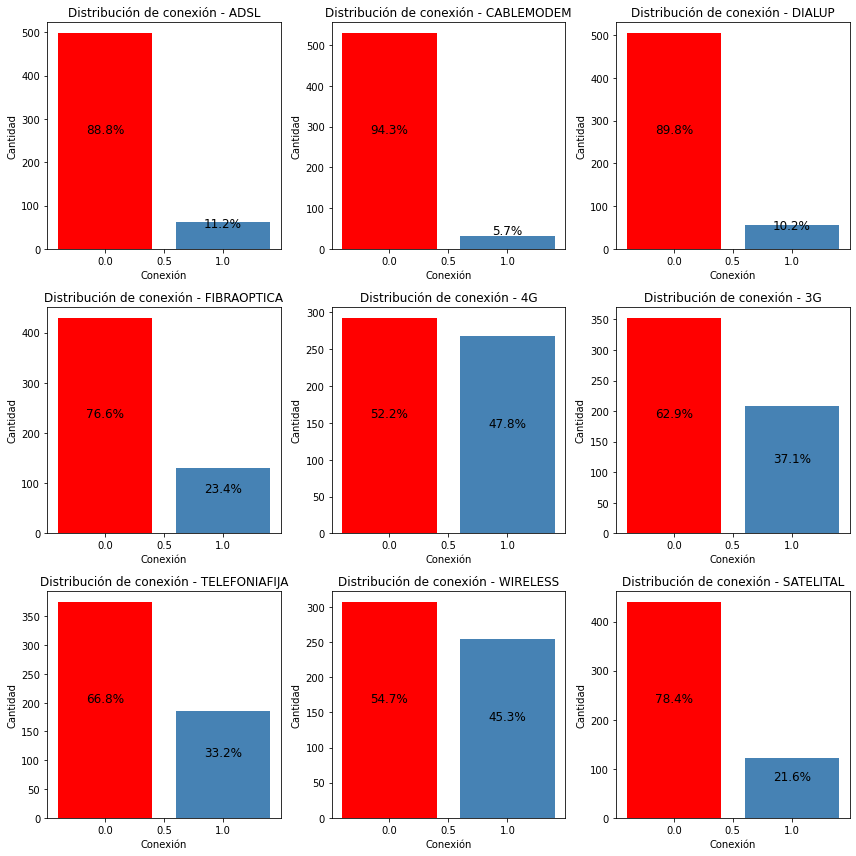

In [3]:
# a) Explorar la distribución de la conexión a diferentes tipos de servicios de telecomunicaciones
# Crear una figura y un arreglo de subfiguras 3x3
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

# Lista de servicios
servicios = ['ADSL', 'CABLEMODEM', 'DIALUP', 'FIBRAOPTICA', '4G', '3G', 'TELEFONIAFIJA', 'WIRELESS', 'SATELITAL']

# Contador para controlar las posiciones de las subfiguras
contador = 0

# Graficar en cada subfigura
for i in range(3):
    for j in range(3):
        # Verificar si quedan servicios por graficar
        if contador < len(servicios):
            servicio = servicios[contador]
            
            # Generar la gráfica en la subfigura correspondiente
            ax = axes[i, j]
            values = df_localidades_conect_RO[servicio].value_counts().values
            labels = df_localidades_conect_RO[servicio].value_counts().index
            
            colors = ['red' if label == 0 else 'steelblue' for label in labels]
            ax.bar(labels, values, color=colors)
            ax.set_title(f"Distribución de conexión - {servicio}")
            ax.set_xlabel("Conexión")
            ax.set_ylabel("Cantidad")
            
            # Agregar los valores porcentuales a las barras
            total = sum(values)
            for rect in ax.patches:
                height = rect.get_height()
                percentage = f"{height/total*100:.1f}%"
                x = rect.get_x() + rect.get_width() / 2
                y = height/2
                ax.annotate(percentage, xy=(x, y), xytext=(0, 5),
                            textcoords="offset points", ha='center', va='bottom',
                            color='black', fontsize=12) #, weight='bold')
            
            # Incrementar el contador
            contador += 1
        else:
            # Si no quedan servicios por graficar, ocultar la subfigura
            axes[i, j].axis('off')

# Ajustar espaciado entre subfiguras
plt.tight_layout()

# Mostrar la figura
plt.show()

> A excepción de la tecnología 4G, 3G y Wireless, existe marcadamente una mayor cantidad de localidades que no cuentan con conectividad. Debido a que este tipo de tecnología de acceso (4G, 3G y Wireless) es empleada para las prestaciones IoT, se ve favorable la posibilidad de implementación de soluciones IoT en estas localidades.

In [ ]:
# Filtrar los datos para conexiones activas ('1')
df_conexiones_activas = df_localidades_conect_RO[df_localidades_conect_RO['CONEXION'] == 1]

# Crear un histograma utilizando seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_conexiones_activas, x='TECNOLOGIA', kde=True, stat='density')

# Obtener los valores únicos de tecnologías
tecnologias = df_conexiones_activas['TECNOLOGIA'].unique()

# Graficar la envolvente sobre el histograma
for tecnologia in tecnologias:
    data = df_conexiones_activas[df_conexiones_activas['TECNOLOGIA'] == tecnologia]['DESCRIPCION'].values
    sns.kdeplot(data, color='red', linewidth=2, linestyle='dashed', label=tecnologia)

# Configurar los ejes y el título
plt.xlabel('Tecnología')
plt.ylabel('Densidad')
plt.title('Distribución de conexiones activas por tecnología')

# Mostrar la leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


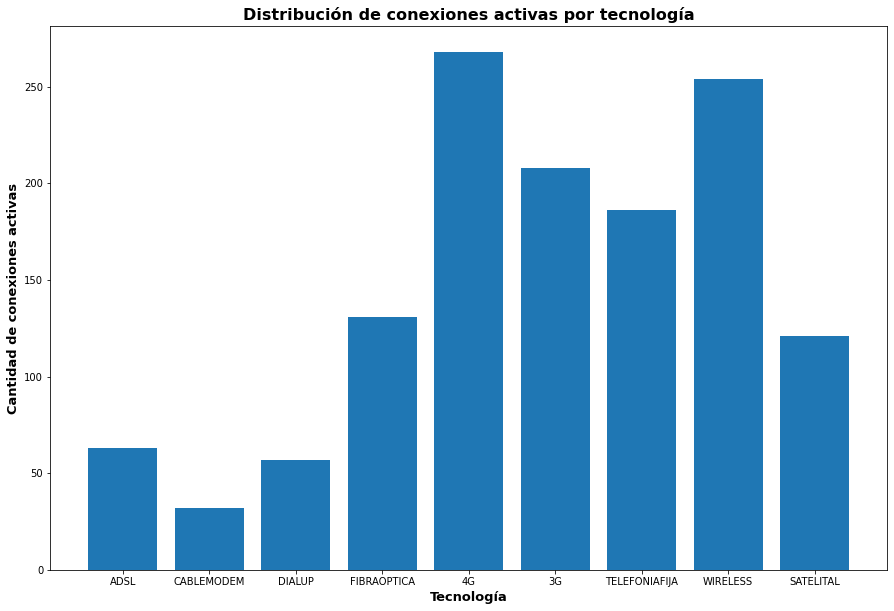

In [8]:
# Contar los valores '1' en cada columna de tecnología
counts = df_localidades_conect_RO[servicios].eq(1).sum()

# Crear un histograma de las conexiones activas
plt.figure(figsize=(15, 10))
plt.bar(counts.index, counts.values)

# Configurar los ejes y el título
plt.xlabel('Tecnología', fontsize=13, fontweight='bold')
plt.ylabel('Cantidad de conexiones activas', fontsize=13, fontweight='bold')
plt.title('Distribución de conexiones activas por tecnología', fontsize=16, fontweight='bold')

# Mostrar el gráfico
plt.show()


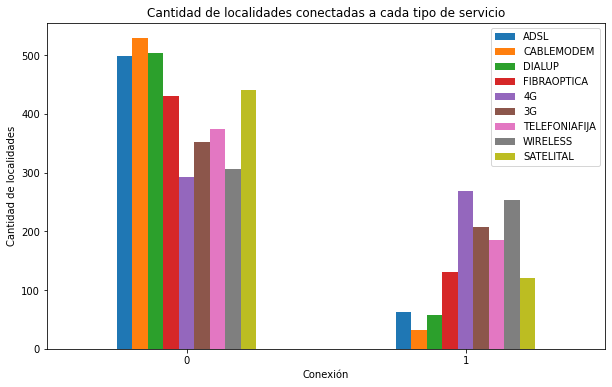

In [187]:
# b) Calcular la cantidad de localidades conectadas a cada tipo de servicio y visualizar los resultados
conexiones = df_localidades_conect_RO[servicios].apply(pd.Series.value_counts)
conexiones.plot(kind='bar', figsize=(10, 6))
plt.title("Cantidad de localidades conectadas a cada tipo de servicio")
plt.xlabel("Conexión")
plt.ylabel("Cantidad de localidades")
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

> Se observa que la mayoría de las localidades que cuentan con conectividad, tienen tecnología 4G, 3G y Wireless

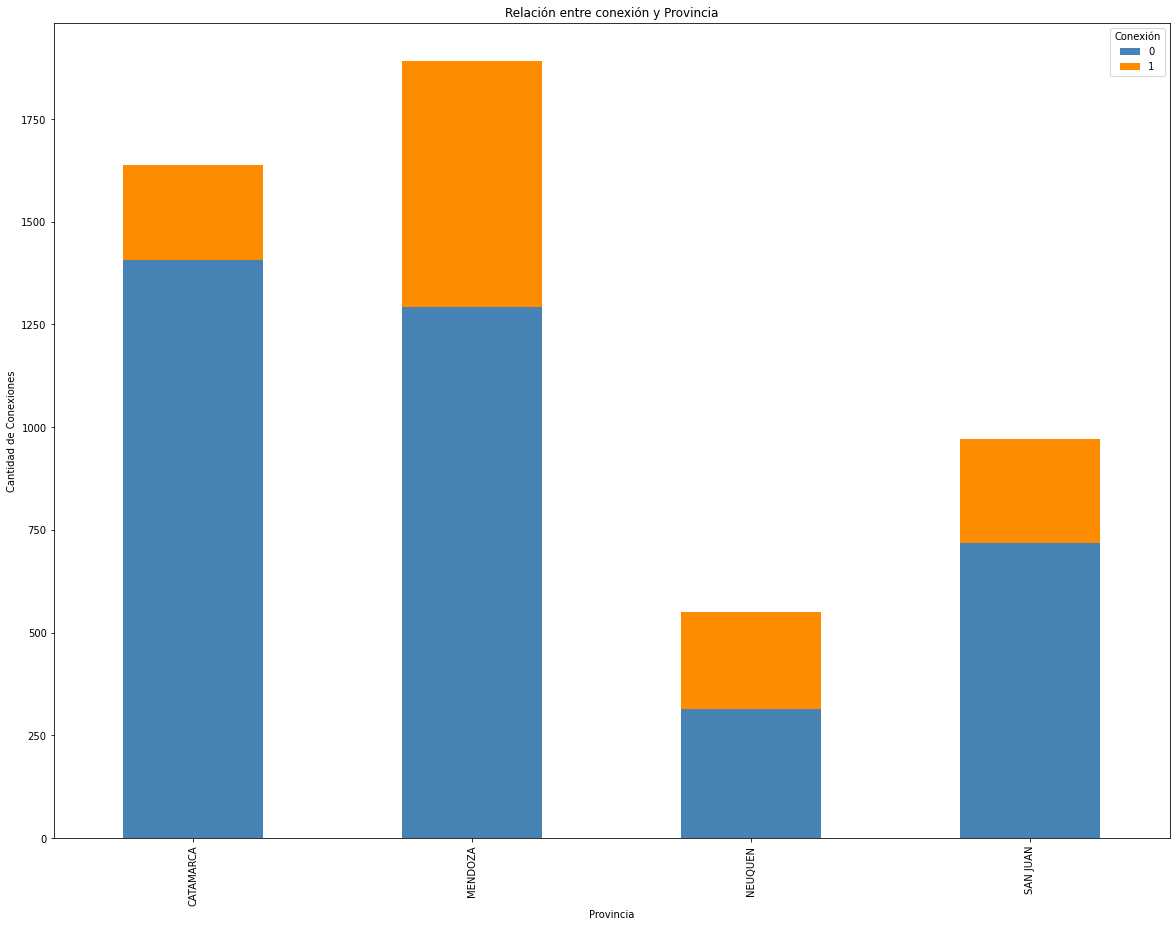

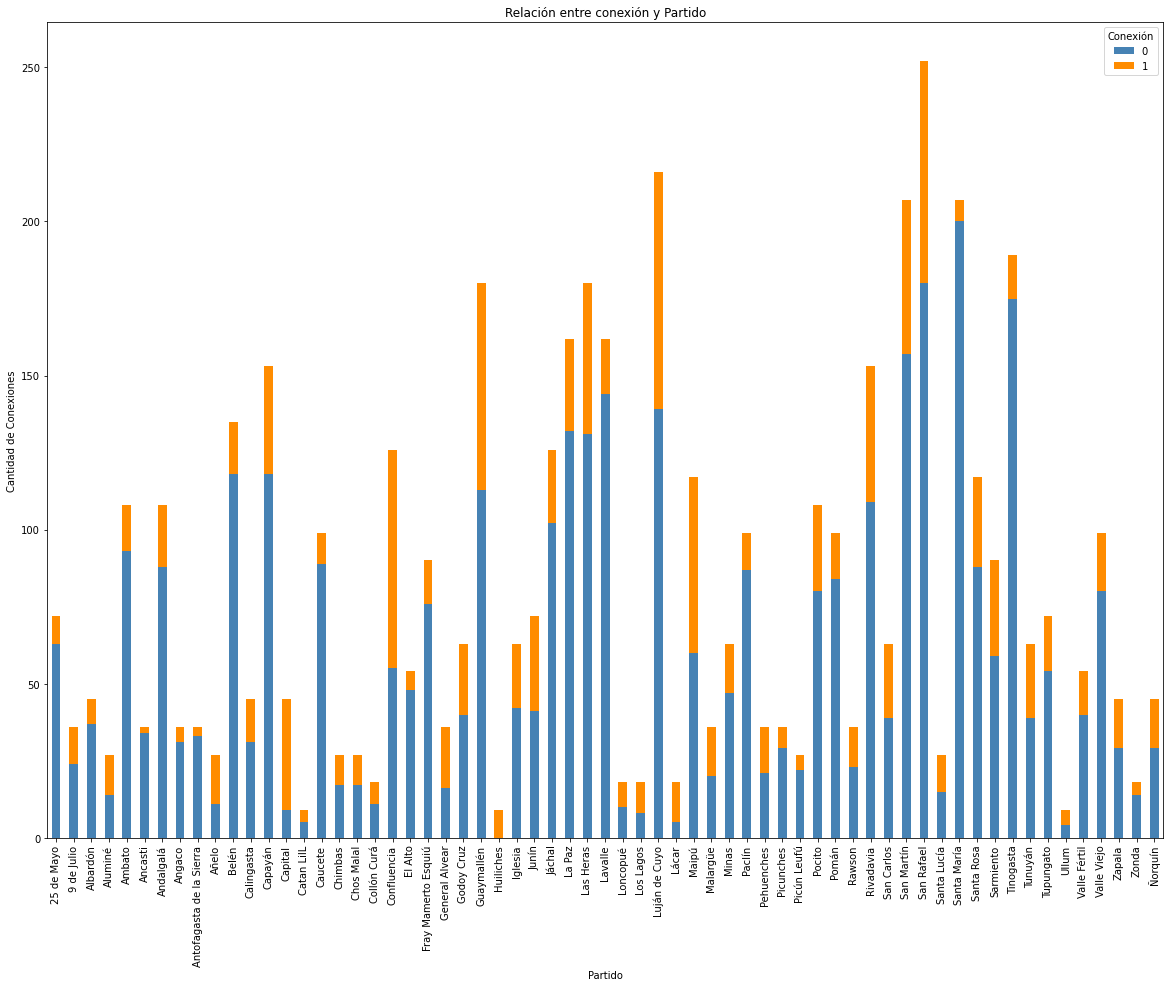

In [61]:
# c) Investigar la relación entre las variables de conexión y las ubicaciones geográficas
# Relación entre conexión y Provincia
import matplotlib.pyplot as plt

# Crear una lista de colores para cada tecnología de conexión
colores = ['steelblue', 'darkorange', 'limegreen', 'red', 'purple', 'yellow', 'cyan', 'pink', 'gray']

# Obtener los valores de conexión para cada ubicación geográfica
valores_provincia = df_melt.groupby('Provincia')['Conexión'].value_counts().unstack().fillna(0)
valores_partido = df_melt.groupby('Partido')['Conexión'].value_counts().unstack().fillna(0)

# Calcular los porcentajes de cada tecnología de conexión por Provincia y Partido
porcentajes_provincia = valores_provincia.div(valores_provincia.sum(axis=1), axis=0)
porcentajes_partido = valores_partido.div(valores_partido.sum(axis=1), axis=0)

# Generar el gráfico de barras apiladas para Provincia
fig, ax1 = plt.subplots(figsize=(20, 15))
valores_provincia.plot(kind='bar', stacked=True, color=colores, ax=ax1)
ax1.set_xlabel('Provincia')
ax1.set_ylabel('Cantidad de Conexiones')
ax1.set_title('Relación entre conexión y Provincia')

# Mostrar los valores porcentuales en el gráfico de Provincia
# for i, columna in enumerate(porcentajes_provincia.columns):
#     total_porcentaje = 0
#     for j, valor in enumerate(porcentajes_provincia[columna]):
#         total_porcentaje += valor
#         ax1.text(i, total_porcentaje / 2, f'{valor:.1%}', ha='center', va='center')

# Generar el gráfico de barras apiladas para Partido
fig, ax2 = plt.subplots(figsize=(20, 15))
valores_partido.plot(kind='bar', stacked=True, color=colores, ax=ax2)
ax2.set_xlabel('Partido')
ax2.set_ylabel('Cantidad de Conexiones')
ax2.set_title('Relación entre conexión y Partido')

# Mostrar los gráficos
plt.show()





> Ambas gráficas confirman que en proporción es menor la cantidad de conexiones, tanto para cada Provincia como para cada Partido.

### df_penetr_100_hog_prov_RO
- Examinar la tendencia de la penetración de accesos a servicios de telecomunicaciones por cada 100 hogares a lo largo de los años y trimestres<br>
- Analizar la distribución de la penetración por provincia<br>
- Identificar las provincias con la mayor y menor penetración de servicios de telecomunicaciones

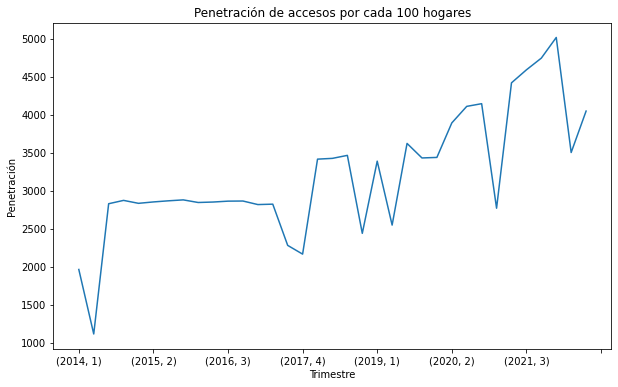

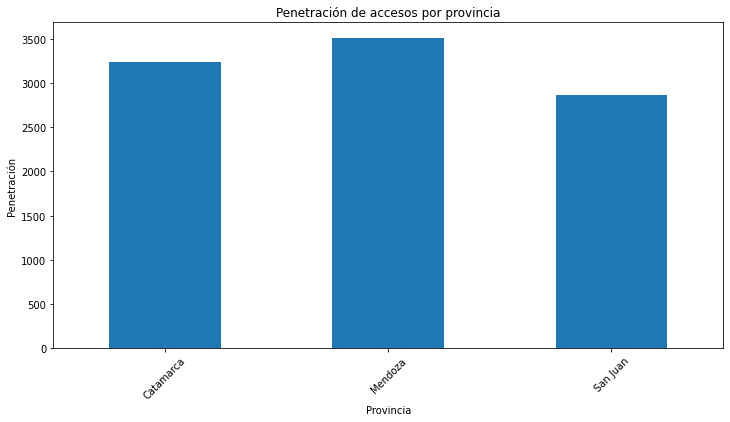

Provincia con mayor penetración: Mendoza
Provincia con menor penetración: San Juan


In [62]:
# Cargar el conjunto de datos
df_penetr_100_hog_prov_RO = pd.read_csv("DatasetRO/penetr_RO.csv")

# Examinar la tendencia de la penetración de accesos a servicios de telecomunicaciones por cada 100 hogares a lo largo de los años y trimestres
plt.figure(figsize=(10, 6))
df_penetr_100_hog_prov_RO.groupby(['Año', 'Trimestre'])['Accesos por cada 100 hogares'].mean().plot()
plt.title("Penetración de accesos por cada 100 hogares")
plt.xlabel("Trimestre")
plt.ylabel("Penetración")
plt.show()

# Analizar la distribución de la penetración por provincia
plt.figure(figsize=(12, 6))
df_penetr_100_hog_prov_RO.groupby('Provincia')['Accesos por cada 100 hogares'].mean().plot(kind='bar')
plt.title("Penetración de accesos por provincia")
plt.xlabel("Provincia")
plt.ylabel("Penetración")
plt.xticks(rotation=45)
plt.show()

# Identificar las provincias con la mayor y menor penetración de servicios de telecomunicaciones
provincia_mayor_penetracion = df_penetr_100_hog_prov_RO.groupby('Provincia')['Accesos por cada 100 hogares'].mean().idxmax()
provincia_menor_penetracion = df_penetr_100_hog_prov_RO.groupby('Provincia')['Accesos por cada 100 hogares'].mean().idxmin()

print("Provincia con mayor penetración:", provincia_mayor_penetracion)
print("Provincia con menor penetración:", provincia_menor_penetracion)


> Se puede observar en la primer gráfica, que la tendencia en la Penetración de accesos ha ido en aumento en los últimos años, augurando conatr cada vez con más localidades con servicio. Este es un buen indicador para proyectar inversiones en el rubro.<br>
> En el segundo gráfico se observa que la provincia de Mendoza es la que cuenta con mayor penetración de accesos entre las provincias analizadas (pronvicias mineras)

### df_BAF_prov_RO

a) Analizar la evolución de la banda ancha fija y el dial-up a lo largo del tiempo (Año y Trimestre)

In [193]:
# Cargar el conjunto de datos
df_BAF_prov_RO = pd.read_csv("DatasetRO/BAF_RO.csv")
df_BAF_prov_RO.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Año               105 non-null    object 
 1   Trimestre         105 non-null    int64  
 2   Provincia         105 non-null    object 
 3   Banda ancha fija  105 non-null    float64
 4   Dial up           105 non-null    float64
 5   Total             105 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 5.0+ KB


In [195]:
# Convertir el campo 'Año' al formato de año
df_BAF_prov_RO['Año'] = pd.to_datetime(df_BAF_prov_RO['Año'], format='%Y-%m-%d').dt.year

# Verificar los cambios
# print(df_BAF_prov_RO['Año'])

df_BAF_prov_RO.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Año               105 non-null    int32  
 1   Trimestre         105 non-null    int64  
 2   Provincia         105 non-null    object 
 3   Banda ancha fija  105 non-null    float64
 4   Dial up           105 non-null    float64
 5   Total             105 non-null    float64
dtypes: float64(3), int32(1), int64(1), object(1)
memory usage: 4.6+ KB


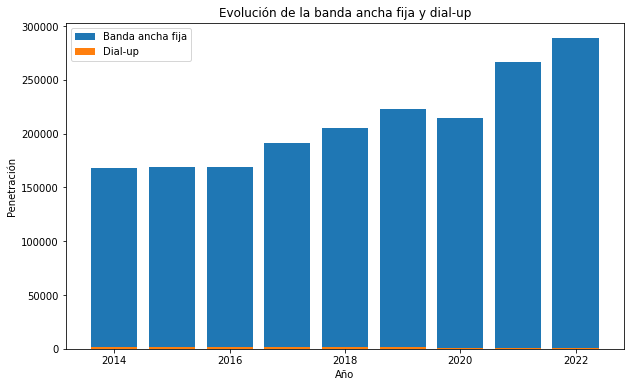

In [197]:
# Crear una figura y ejes para el gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Graficar la evolución de la banda ancha fija y el dial-up a lo largo del tiempo
ax.bar(df_BAF_prov_RO['Año'], df_BAF_prov_RO['Banda ancha fija'], label='Banda ancha fija')
ax.bar(df_BAF_prov_RO['Año'], df_BAF_prov_RO['Dial up'], label='Dial-up')

# Configurar etiquetas y títulos
ax.set_title("Evolución de la banda ancha fija y dial-up")
ax.set_xlabel("Año")
ax.set_ylabel("Penetración")
ax.legend()

# Mostrar el gráfico
plt.show()


> Se observa claramente que el crecimiento de la conectividad por Banda Ancha ha sido sostenido en los últimos años, no ocurriendo lo mismo con la tecnología Dial-up

b) Comparar la penetración de la banda ancha fija y el dial-up en diferentes provincias

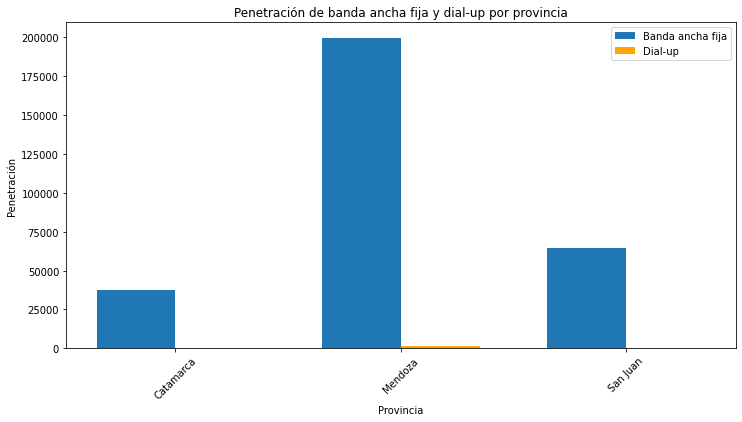

In [201]:
# Comparar la penetración de la banda ancha fija y el dial-up por provincia
fig, ax = plt.subplots(figsize=(12, 6))

# Obtener los datos de penetración por provincia
banda_ancha_fija = df_BAF_prov_RO.groupby('Provincia')['Banda ancha fija'].mean()
dial_up = df_BAF_prov_RO.groupby('Provincia')['Dial up'].mean()

# Calcular el ancho de las barras
bar_width = 0.35

# Calcular la posición de las barras para que estén una al lado de la otra
r1 = np.arange(len(banda_ancha_fija))
r2 = [x + bar_width for x in r1]

# Graficar la penetración de la banda ancha fija
ax.bar(r1, banda_ancha_fija, width=bar_width, label='Banda ancha fija')

# Graficar la penetración del dial-up
ax.bar(r2, dial_up, color='orange', width=bar_width, label='Dial-up')

# Configurar etiquetas y títulos
ax.set_title("Penetración de banda ancha fija y dial-up por provincia")
ax.set_xlabel("Provincia")
ax.set_ylabel("Penetración")
ax.set_xticks(r1 + bar_width / 2)
ax.set_xticklabels(banda_ancha_fija.index, rotation=45)
ax.legend()

# Mostrar el gráfico
plt.show()



> La penetración de la tecnología de Banda Ancha es muy superior a la de Dial-up, para cada una de las provincias analizadas.

## Conclusiones preliminares

A partir del análisis de la evolución de la penetración de las tecnología de acceso a internet, y de la capacidad de conectividad existente en la actualidad, se concluye que el escenario es prometedor para poder ofrecer servicios en el campo de IoT en la región analizada.<br>
Para poder profundizar en el análisis, se realizará la ingesta de datos en PowerBI para analizar la interacción de las diferentes variables y el impacto en los KPIs definidos.<br>